In [25]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import importlib
warnings.filterwarnings('ignore')

# Project imports
import sys
sys.path.append('..')
from src.config import (
    SEED, DATA_DIR, FIGURES_DIR,
    ID_COL, TARGET_COL, CLAIM_NB_COL, EXPOSURE_COL,
    CATEGORICAL_FEATURES, NUMERICAL_FEATURES, ALL_FEATURES,
    ORDINAL_FEATURES, NOMINAL_FEATURES, AREA_ORDER
)
from src.utils import evaluate_regression, print_metrics

# Import from-scratch Decision Tree
import src.decision_tree as dt_module
importlib.reload(dt_module)
from src.decision_tree import DecisionTreeRegressor

# sklearn for reference implementation and preprocessing
from sklearn.tree import DecisionTreeRegressor as SklearnTree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold

# Set random seed for reproducibility
np.random.seed(SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Imports successful")
print(f"Random seed: {SEED}")
print(f"Data directory: {DATA_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

Imports successful
Random seed: 42
Data directory: /Users/matteo/Desktop/TRYG_ML/notebooks/../data
Figures directory: /Users/matteo/Desktop/TRYG_ML/notebooks/../figures


In [ ]:
# Load training and test data
df_train = pd.read_csv(DATA_DIR / 'claims_train.csv')
df_test = pd.read_csv(DATA_DIR / 'claims_test.csv')

# Data cleaning: remove observations with Exposure > 1 (invalid data)
df_train = df_train[df_train[EXPOSURE_COL] <= 1].copy()

# Create target variable: ClaimFrequency = ClaimNb / Exposure
df_train[TARGET_COL] = df_train[CLAIM_NB_COL] / df_train[EXPOSURE_COL]
df_test[TARGET_COL] = df_test[CLAIM_NB_COL] / df_test[EXPOSURE_COL]

# Prepare features (X) and target (y)
X_train_full = df_train[ALL_FEATURES]
y_train_full = df_train[TARGET_COL]
X_test = df_test[ALL_FEATURES]
y_test = df_test[TARGET_COL]

# Setup 5-fold cross-validation (test set held out for final evaluation only)
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

print(f"Train: {len(X_train_full):,} samples, Test: {len(X_test):,} samples ")
print(f"Target - Mean: {y_train_full.mean():.4f}, Std: {y_train_full.std():.4f}, Max: {y_train_full.max():.1f}")

Train: 541,416 samples, Test: 135,603 samples (held out)
Target - Mean: 0.2616, Std: 4.4322, Max: 732.0


In [27]:
# From-scratch Decision Tree with 5-fold cross-validation
# - Handles categorical features natively (no encoding needed)
# - Uses mean-based ordering for categorical splits
# - Uses sorted arrays for numerical splits

import time

# Cross-validation function for from-scratch tree
def cv_scratch_tree(X, y, max_depth, min_samples_split, min_samples_leaf, kfold, verbose=False):
    cv_scores = {'R2': [], 'RMSE': [], 'MAE': [], 'MSE': []}
    cv_times = []
    
    X_arr = X.values if hasattr(X, 'values') else X
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_arr)):
        X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
        
        tree = DecisionTreeRegressor(
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, random_state=SEED, verbose=verbose)
        
        start = time.time()
        tree.fit(X_tr, y_tr, feature_names=ALL_FEATURES, categorical_features=CATEGORICAL_FEATURES)
        cv_times.append(time.time() - start)
        
        metrics = evaluate_regression(y_vl, tree.predict(X_vl))
        for key in cv_scores:
            cv_scores[key].append(metrics[key])
    
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}, np.mean(cv_times), tree

# Run CV with initial parameters
print("FROM-SCRATCH TREE (5-fold CV)")
cv_results_scratch, avg_time_scratch, last_tree_scratch = cv_scratch_tree(
    X_train_full, y_train_full, max_depth=5, min_samples_split=100, min_samples_leaf=50, kfold=kfold)

print(f"  MAE:  {cv_results_scratch['MAE'][0]:.4f} ± {cv_results_scratch['MAE'][1]:.4f}")
print(f"  RMSE: {cv_results_scratch['RMSE'][0]:.4f} ± {cv_results_scratch['RMSE'][1]:.4f}")
print(f"  Time/fold: {avg_time_scratch:.2f}s")

# Tree structure analysis
split_summary = last_tree_scratch.get_split_summary()
print(f"\nTree structure: {last_tree_scratch.get_n_leaves()} leaves, depth={last_tree_scratch.get_depth()}")
print(f"Splits: {split_summary['numerical_splits']} numerical, {split_summary['categorical_splits']} categorical")


FROM-SCRATCH TREE (5-fold CV)
  MAE:  0.4811 ± 0.0089
  RMSE: 4.3995 ± 0.4175
  Time/fold: 8.01s

Tree structure: 31 leaves, depth=5
Splits: 12 numerical, 18 categorical


In [28]:
# Feature importance from last CV fold
print("Top features by importance:")
for feat, imp in sorted(split_summary['feature_importances'].items(), key=lambda x: -x[1])[:5]:
    print(f"  {feat}: {imp:.4f}")

Top features by importance:
  VehAge: 0.2901
  VehPower: 0.1546
  VehGas: 0.1511
  VehBrand: 0.1448
  Density: 0.1109


In [29]:
# Sklearn reference implementation with 5-fold CV
# Requires encoding: Ordinal for Area, One-hot for VehBrand/VehGas/Region

def cv_sklearn_tree(X_df, y, max_depth, min_samples_split, min_samples_leaf, kfold):
    cv_scores = {'R2': [], 'RMSE': [], 'MAE': [], 'MSE': []}
    cv_times = []
    
    X_arr = X_df.values if hasattr(X_df, 'values') else X_df
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_arr)):
        X_tr, X_vl = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
        
        # Encode features (fit on train fold only to prevent leakage)
        ordinal_enc = OrdinalEncoder(categories=[AREA_ORDER])
        onehot_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        
        X_tr_enc = np.hstack([X_tr[NUMERICAL_FEATURES].values,
                             ordinal_enc.fit_transform(X_tr[ORDINAL_FEATURES]),
                             onehot_enc.fit_transform(X_tr[NOMINAL_FEATURES])])
        X_vl_enc = np.hstack([X_vl[NUMERICAL_FEATURES].values,
                             ordinal_enc.transform(X_vl[ORDINAL_FEATURES]),
                             onehot_enc.transform(X_vl[NOMINAL_FEATURES])])
        
        tree = SklearnTree(max_depth=max_depth, min_samples_split=min_samples_split,
                          min_samples_leaf=min_samples_leaf, random_state=SEED)
        
        start = time.time()
        tree.fit(X_tr_enc, y_tr)
        cv_times.append(time.time() - start)
        
        metrics = evaluate_regression(y_vl, tree.predict(X_vl_enc))
        for key in cv_scores:
            cv_scores[key].append(metrics[key])
    
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}, np.mean(cv_times), tree

# Run CV with same parameters as scratch tree
print("SKLEARN TREE (5-fold CV)")
cv_results_sklearn, avg_time_sklearn, last_tree_sklearn = cv_sklearn_tree(
    X_train_full, y_train_full, max_depth=5, min_samples_split=100, min_samples_leaf=50, kfold=kfold)

# Calculate number of encoded features
temp_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
temp_ohe.fit(X_train_full[NOMINAL_FEATURES])
n_features_enc = len(NUMERICAL_FEATURES) + len(ORDINAL_FEATURES) + len(temp_ohe.get_feature_names_out())

print(f"  Features: {len(ALL_FEATURES)} → {n_features_enc} (after encoding)")
print(f"  MAE:  {cv_results_sklearn['MAE'][0]:.4f} ± {cv_results_sklearn['MAE'][1]:.4f}")
print(f"  RMSE: {cv_results_sklearn['RMSE'][0]:.4f} ± {cv_results_sklearn['RMSE'][1]:.4f}")
print(f"  Time/fold: {avg_time_sklearn:.2f}s")

SKLEARN TREE (5-fold CV)
  Features: 9 → 38 (after encoding)
  MAE:  0.4813 ± 0.0092
  RMSE: 4.3991 ± 0.4175
  Time/fold: 1.79s


In [30]:
# Implementation comparison: From-scratch vs Sklearn
print("COMPARISON: Scratch vs Sklearn")
print(f"  MAE diff:   {abs(cv_results_scratch['MAE'][0] - cv_results_sklearn['MAE'][0]):.6f}")
print(f"  RMSE diff:  {abs(cv_results_scratch['RMSE'][0] - cv_results_sklearn['RMSE'][0]):.6f}")
print(f"  Speedup:    {avg_time_scratch / avg_time_sklearn:.1f}x (sklearn faster)")


COMPARISON: Scratch vs Sklearn
  MAE diff:   0.000210
  RMSE diff:  0.000386
  Speedup:    4.5x (sklearn faster)


In [31]:
# Detailed comparison table
# Note: Similar performance expected despite different feature handling
# - Scratch: works with raw categorical features (9 total)
# - Sklearn: requires encoding (38 features after one-hot)
comparison = pd.DataFrame({
    'Model': ['Scratch', 'Sklearn'],
    'MAE_mean': [cv_results_scratch['MAE'][0], cv_results_sklearn['MAE'][0]],
    'MAE_std': [cv_results_scratch['MAE'][1], cv_results_sklearn['MAE'][1]],
    'RMSE_mean': [cv_results_scratch['RMSE'][0], cv_results_sklearn['RMSE'][0]],
    'Time_s': [avg_time_scratch, avg_time_sklearn]
})
print(comparison.to_string(index=False))


  Model  MAE_mean  MAE_std  RMSE_mean   Time_s
Scratch  0.481081 0.008933   4.399529 8.007462
Sklearn  0.481291 0.009248   4.399143 1.790355


In [32]:
# HYPERPARAMETER TUNING: max_depth
# Depth selection rationale:
#   - depth=3: Shallow (8 leaves max) - strong regularization
#   - depth=5: Moderate (32 leaves max) - balance bias/variance
#   - depth=7: Deeper (128 leaves max) - more flexibility
#   - depth=10: Deep (1024 leaves max) - risk of overfitting
# For insurance data with extreme outliers, shallow trees often generalize better.
# Using MAE for selection as it's more robust to outliers than R².

depths = [3, 5, 7, 10]
results_depth = []

print("TUNING: max_depth (selecting by MAE)")
for depth in depths:
    cv_results, avg_time, last_tree = cv_scratch_tree(
        X_train_full, y_train_full, max_depth=depth, 
        min_samples_split=100, min_samples_leaf=50, kfold=kfold)
    
    results_depth.append({
        'depth': depth, 'MAE_mean': cv_results['MAE'][0], 'MAE_std': cv_results['MAE'][1],
        'RMSE_mean': cv_results['RMSE'][0], 'RMSE_std': cv_results['RMSE'][1],
        'leaves': last_tree.get_n_leaves(), 'time_s': avg_time * K_FOLDS})
    
    print(f"  depth={depth}: MAE={cv_results['MAE'][0]:.4f}±{cv_results['MAE'][1]:.4f}, leaves={last_tree.get_n_leaves()}")

df_depth = pd.DataFrame(results_depth)
best_depth = df_depth.loc[df_depth['MAE_mean'].idxmin(), 'depth']
print(f"\nBest: max_depth={int(best_depth)}")


TUNING: max_depth (selecting by MAE)
  depth=3: MAE=0.4835±0.0077, leaves=8
  depth=5: MAE=0.4811±0.0089, leaves=31
  depth=7: MAE=0.4799±0.0084, leaves=100
  depth=10: MAE=0.4786±0.0094, leaves=431

Best: max_depth=10


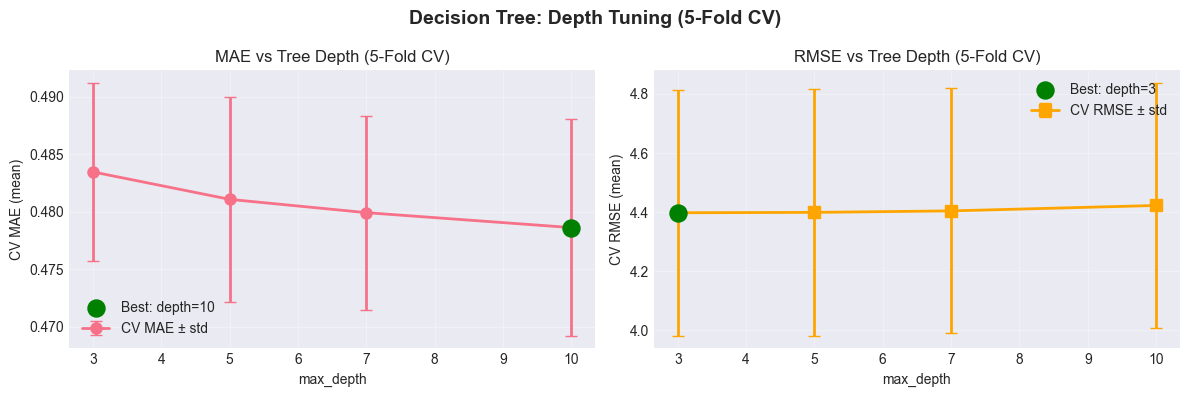

Figure saved to: /Users/matteo/Desktop/TRYG_ML/notebooks/../figures/decision_tree_depth_tuning.png


In [33]:
# Visualization: Depth tuning results (5-Fold CV)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# MAE vs depth (with error bars) - lower is better
axes[0].errorbar(df_depth['depth'], df_depth['MAE_mean'], yerr=df_depth['MAE_std'], 
                 fmt='o-', linewidth=2, markersize=8, capsize=4, label='CV MAE ± std')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('CV MAE (mean)')
axes[0].set_title('MAE vs Tree Depth (5-Fold CV)')
axes[0].grid(True, alpha=0.3)

best_mae_idx = df_depth['MAE_mean'].idxmin()
axes[0].scatter([df_depth.loc[best_mae_idx, 'depth']], [df_depth.loc[best_mae_idx, 'MAE_mean']], 
                color='green', s=150, zorder=5, label=f"Best: depth={int(df_depth.loc[best_mae_idx, 'depth'])}")
axes[0].legend()

# RMSE vs depth (with error bars) - lower is better
axes[1].errorbar(df_depth['depth'], df_depth['RMSE_mean'], yerr=df_depth['RMSE_std'],
                 fmt='s-', linewidth=2, markersize=8, color='orange', capsize=4, label='CV RMSE ± std')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('CV RMSE (mean)')
axes[1].set_title('RMSE vs Tree Depth (5-Fold CV)')
axes[1].grid(True, alpha=0.3)

best_rmse_idx = df_depth['RMSE_mean'].idxmin()
axes[1].scatter([df_depth.loc[best_rmse_idx, 'depth']], [df_depth.loc[best_rmse_idx, 'RMSE_mean']], 
                color='green', s=150, zorder=5, label=f"Best: depth={int(df_depth.loc[best_rmse_idx, 'depth'])}")
axes[1].legend()

plt.suptitle('Decision Tree: Depth Tuning (5-Fold CV)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'decision_tree_depth_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {FIGURES_DIR / 'decision_tree_depth_tuning.png'}")

In [34]:
# HYPERPARAMETER TUNING: min_samples_split & min_samples_leaf
# Rationale: With max_depth=3 and ~540k samples, each leaf has ~67k samples.
# Test increasing regularization levels:
#   - (100, 50):     Minimal constraint
#   - (1000, 500):   Moderate constraint
#   - (5000, 2500):  Strong constraint
#   - (10000, 5000): Very strong constraint
# Note: When depth is binding, min_samples may have limited effect.
# Using MAE for selection as it's more robust to outliers.

param_grid = [
    {'min_samples_split': 100, 'min_samples_leaf': 50},
    {'min_samples_split': 1000, 'min_samples_leaf': 500}, 
    {'min_samples_split': 5000, 'min_samples_leaf': 2500},
    {'min_samples_split': 10000, 'min_samples_leaf': 5000},
]

results_params = []
print(f"TUNING: min_samples (fixed max_depth={int(best_depth)}, selecting by MAE)")
for params in param_grid:
    mss, msl = params['min_samples_split'], params['min_samples_leaf']
    cv_results, avg_time, last_tree = cv_scratch_tree(
        X_train_full, y_train_full, max_depth=int(best_depth), 
        min_samples_split=mss, min_samples_leaf=msl, kfold=kfold)
    
    results_params.append({
        'mss': mss, 'msl': msl, 'MAE_mean': cv_results['MAE'][0], 'MAE_std': cv_results['MAE'][1],
        'RMSE_mean': cv_results['RMSE'][0], 'leaves': last_tree.get_n_leaves()})
    print(f"  mss={mss}, msl={msl}: MAE={cv_results['MAE'][0]:.4f}±{cv_results['MAE'][1]:.4f}")

df_params = pd.DataFrame(results_params)
best_param_idx = df_params['MAE_mean'].idxmin()
best_mss = int(df_params.loc[best_param_idx, 'mss'])
best_msl = int(df_params.loc[best_param_idx, 'msl'])
print(f"\nBest: min_samples_split={best_mss}, min_samples_leaf={best_msl}")

TUNING: min_samples (fixed max_depth=10, selecting by MAE)
  mss=100, msl=50: MAE=0.4786±0.0094
  mss=1000, msl=500: MAE=0.4797±0.0082
  mss=5000, msl=2500: MAE=0.4803±0.0082
  mss=10000, msl=5000: MAE=0.4840±0.0080

Best: min_samples_split=100, min_samples_leaf=50


In [35]:
# Train final model on full training set with best hyperparameters
print(f"FINAL MODEL: depth={int(best_depth)}, mss={best_mss}, msl={best_msl}")

final_tree = DecisionTreeRegressor(
    max_depth=int(best_depth), min_samples_split=best_mss,
    min_samples_leaf=best_msl, random_state=SEED, verbose=False)

start_time = time.time()
final_tree.fit(X_train_full, y_train_full, feature_names=ALL_FEATURES, categorical_features=CATEGORICAL_FEATURES)
print(f"Training time: {time.time() - start_time:.1f}s, Leaves: {final_tree.get_n_leaves()}")


FINAL MODEL: depth=10, mss=100, msl=50
Training time: 30.0s, Leaves: 485


In [36]:
# Evaluate final model on held-out test set
y_train_pred = final_tree.predict(X_train_full)
y_test_pred = final_tree.predict(X_test)

train_metrics = evaluate_regression(y_train_full, y_train_pred)
test_metrics = evaluate_regression(y_test, y_test_pred)

print("FINAL MODEL EVALUATION")
print("\nTrain set:")
print_metrics(train_metrics, "Train")
print("\nTest set:")
print_metrics(test_metrics, "Test")

# Generalization check
r2_gap = train_metrics['R2'] - test_metrics['R2']
rmse_gap = test_metrics['RMSE'] - train_metrics['RMSE']
print(f"\nGeneralization:")
print(f"  R² gap (train-test):   {r2_gap:.6f}")
print(f"  RMSE gap (test-train): {rmse_gap:.4f}")



FINAL MODEL EVALUATION

Train set:

Train Performance:
  MSE       : 19.114729
  RMSE      : 4.372039
  MAE       : 0.473004
  R2        : 0.026946

Test set:

Test Performance:
  MSE       : 27.073594
  RMSE      : 5.203229
  MAE       : 0.492241
  R2        : 0.000500

Generalization:
  R² gap (train-test):   0.026446
  RMSE gap (test-train): 0.8312
